In [ ]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
sys.path.extend([
    os.path.abspath(os.path.join("../..")),
    os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/"))
])

import tensorflow as tf
from tensorflow_probability import distributions as tfd
import bayesflow as bf

from src.python.settings import plotting_settings, plotting_update

In [2]:
plt.rcParams.update(plotting_update)

## Load summary data

In [3]:
path = "../../data/levy_comparison/predictions"

In [4]:
ensemble_reps = pickle.load(open(f'{path}/preds_sim_powerscaled.pkl', 'rb+'))
ensemble_obs_rep = pickle.load(open(f'{path}/preds_emp_powerscaled.pkl', 'rb+'))

print(ensemble_reps['summary_output'].shape)
print(ensemble_obs_rep['summary_output'].shape)

(20, 8000, 64)
(20, 1, 64)


## Mock-configurator

In [5]:
def configurator(input_dict):
    return {
        'parameters': input_dict['sim_data'],
        # Hack, since amortizers are not unconditional
        'direct_conditions': np.zeros((input_dict['sim_data'].shape[0], 2), dtype=np.float32)
    }

## Data preparation

In [6]:
NUM_ENSEMBLE_MEMBERS = ensemble_reps['summary_output'].shape[0]
SUMMARY_DIM = ensemble_reps['summary_output'].shape[-1]
NUM_VALS = 300
N_EPOCHS = 100
BATCH_SIZE = 32

perm_idx = np.random.default_rng(seed=42).permutation(ensemble_reps['summary_output'].shape[1])
val_idx = perm_idx[:NUM_VALS]
train_idx = perm_idx[NUM_VALS:]

loc = [0.0] * SUMMARY_DIM
scale = tf.linalg.LinearOperatorDiag([1.0] * SUMMARY_DIM)
latent_dist = tfd.MultivariateStudentTLinearOperator(df=100, loc=loc, scale=scale)

## Train networks for all ensemble members

In [7]:
%%capture  
# Reduce clutter from tqdm

if not os.path.exists("net_checkpoints/typical_ensemble_scaled"):  # Only train when there is no checkpoint folder
    with tf.device('/cpu:0'):  # Way faster for these small networks
        for network in range(NUM_ENSEMBLE_MEMBERS):
            print(f'Starting to train network{network}...')
            
            train_data = {
                'sim_data': ensemble_reps['summary_output'][network, train_idx, :]
            }
            val_data = {
                'sim_data': ensemble_reps['summary_output'][network, val_idx, :]
            }
            emp_data = {
                'sim_data': ensemble_obs_rep['summary_output'][network, ...],
            }

            tf.keras.backend.clear_session()
            inference_net = bf.networks.InvertibleNetwork(
                num_params=SUMMARY_DIM, 
                num_coupling_layers=8
            )
            amortizer = bf.amortizers.AmortizedPosterior(inference_net, latent_dist=latent_dist)
            checkpoint_path = f"net_checkpoints/typical_ensemble_scaled/net{network}"
            trainer = bf.trainers.Trainer(
                amortizer=amortizer,
                configurator=configurator,
                checkpoint_path=checkpoint_path
            )
            losses = trainer.train_offline(train_data, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_sims=val_data)

## Validation

In [8]:
# small modification to enable plotting in subplots
def plot_ensemble_losses(
    train_losses,
    val_losses=None,
    moving_average=False,
    ma_window_fraction=0.01,
    fig_size=None,
    train_color="#8f2727",
    val_color="black",
    lw_train=2,
    lw_val=3,
    grid_alpha=0.5,
    legend_fontsize=14,
    label_fontsize=14,
    title_fontsize=16,
    axarr=None
):
    """A generic helper function to plot the losses of a series of training epochs and runs.

    Parameters
    ----------

    train_losses       : pd.DataFrame
        The (plottable) history as returned by a train_[...] method of a ``Trainer`` instance.
        Alternatively, you can just pass a data frame of validation losses instead of train losses,
        if you only want to plot the validation loss.
    val_losses         : pd.DataFrame or None, optional, default: None
        The (plottable) validation history as returned by a train_[...] method of a ``Trainer`` instance.
        If left ``None``, only train losses are plotted. Should have the same number of columns
        as ``train_losses``.
    moving_average     : bool, optional, default: False
        A flag for adding a moving average line of the train_losses.
    ma_window_fraction : int, optional, default: 0.01
        Window size for the moving average as a fraction of total training steps.
    fig_size           : tuple or None, optional, default: None
        The figure size passed to the ``matplotlib`` constructor. Inferred if ``None``
    train_color        : str, optional, default: '#8f2727'
        The color for the train loss trajectory
    val_color          : str, optional, default: black
        The color for the optional validation loss trajectory
    lw_train           : int, optional, default: 2
        The linewidth for the training loss curve
    lw_val             : int, optional, default: 3
        The linewidth for the validation loss curve
    grid_alpha         : float, optional, default 0.5
        The opacity factor for the background gridlines
    legend_fontsize    : int, optional, default: 14
        The font size of the legend text
    label_fontsize     : int, optional, default: 14
        The font size of the y-label text
    title_fontsize     : int, optional, default: 16
        The font size of the title text

    Returns
    -------
    f : plt.Figure - the figure instance for optional saving

    Raises
    ------
    AssertionError
        If the number of columns in ``train_losses`` does not match the
        number of columns in ``val_losses``.
    """

    # Determine the number of rows for plot
    n_row = len(train_losses.columns)

    # Initialize figure
    if fig_size is None:
        fig_size = (25, int(4 * n_row))
    if not axarr:
        f, axarr = plt.subplots(n_row, 1, figsize=fig_size)

    # Get the number of steps as an array
    train_step_index = np.arange(1, len(train_losses) + 1)
    if val_losses is not None:
        val_step = int(np.floor(len(train_losses) / len(val_losses)))
        val_step_index = train_step_index[(val_step - 1) :: val_step]

        # If unequal length due to some reason, attempt a fix
        if val_step_index.shape[0] > val_losses.shape[0]:
            val_step_index = val_step_index[: val_losses.shape[0]]

    # Loop through loss entries and populate plot
    looper = [axarr] if n_row == 1 else axarr.flat
    for i, ax in enumerate(looper):
        # Plot train curve
        ax.plot(train_step_index, train_losses.iloc[:, i], color=train_color, lw=lw_train, alpha=0.9, label="Training")
        if moving_average:
            moving_average_window = int(train_losses.shape[0] * ma_window_fraction)
            smoothed_loss = train_losses.iloc[:, i].rolling(window=moving_average_window).mean()
            ax.plot(train_step_index, smoothed_loss, color="grey", lw=lw_train, label="Training (Moving Average)")

        # Plot optional val curve
        if val_losses is not None:
            if i < val_losses.shape[1]:
                ax.plot(
                    val_step_index,
                    val_losses.iloc[:, i],
                    linestyle="--",
                    marker="o",
                    color=val_color,
                    lw=lw_val,
                    label="Validation",
                )
        # Schmuck
        #ax.set_xlabel("Training step #", fontsize=label_fontsize)
        ax.set_ylabel("Loss", fontsize=label_fontsize)
        sns.despine(ax=ax)
        ax.grid(alpha=grid_alpha)
        #ax.set_title(train_losses.columns[i], fontsize=title_fontsize)
        # Only add legend if there is a validation curve
        if val_losses is not None or moving_average:
            ax.legend(fontsize=legend_fontsize)
    #f.tight_layout()
    #return f

In [ ]:
# Plot Losses for all ensemble members 


fig, ax = plt.subplots(NUM_ENSEMBLE_MEMBERS, 1, figsize=(10, 20))
for network in range(NUM_ENSEMBLE_MEMBERS):
    tf.keras.backend.clear_session()
    inference_net = bf.networks.InvertibleNetwork(
        num_params=SUMMARY_DIM, 
        num_coupling_layers=8
    )
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, latent_dist=latent_dist)
    checkpoint_path = f"net_checkpoints/typical_ensemble_scaled/net{network}"
    trainer = bf.trainers.Trainer(
        amortizer=amortizer,
        configurator=configurator,
        checkpoint_path=checkpoint_path
    )
    losses = trainer.loss_history.get_plottable()

    plot_ensemble_losses(pd.DataFrame(losses['train_losses'].iloc[:,0]), losses['val_losses'], axarr=ax[network])
plt.tight_layout()

## Typicality test

In [ ]:
# Get log pdfs
val_lpdfs = []
emp_lpdfs = []

for network in range(NUM_ENSEMBLE_MEMBERS):
    train_data = {
        'sim_data': ensemble_reps['summary_output'][network, train_idx, :]
    }
    val_data = {
        'sim_data': ensemble_reps['summary_output'][network, val_idx, :]
    }
    emp_data = {
        'sim_data': ensemble_obs_rep['summary_output'][network, ...],
    }

    tf.keras.backend.clear_session()
    inference_net = bf.networks.InvertibleNetwork(
        num_params=SUMMARY_DIM, 
        num_coupling_layers=8
    )
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, latent_dist=latent_dist)
    checkpoint_path = f"net_checkpoints/typical_ensemble_scaled/net{network}"
    trainer = bf.trainers.Trainer(
        amortizer=amortizer,
        configurator=configurator,
        checkpoint_path=checkpoint_path
    )

    val_lpdfs.append(amortizer.log_posterior(configurator(val_data)))
    emp_lpdfs.append(amortizer.log_posterior(configurator(emp_data)))

val_lpdfs_arr = np.concatenate(val_lpdfs)
emp_lpdfs_arr = np.concatenate(emp_lpdfs)

In [11]:
# Kolmogorov Smirnov test
from scipy.stats import kstest

kstest(val_lpdfs_arr, emp_lpdfs_arr)

KstestResult(statistic=0.9463333333333334, pvalue=1.4366416550696797e-25, statistic_location=132.56, statistic_sign=-1)

In [12]:
ALPHA = 0.7

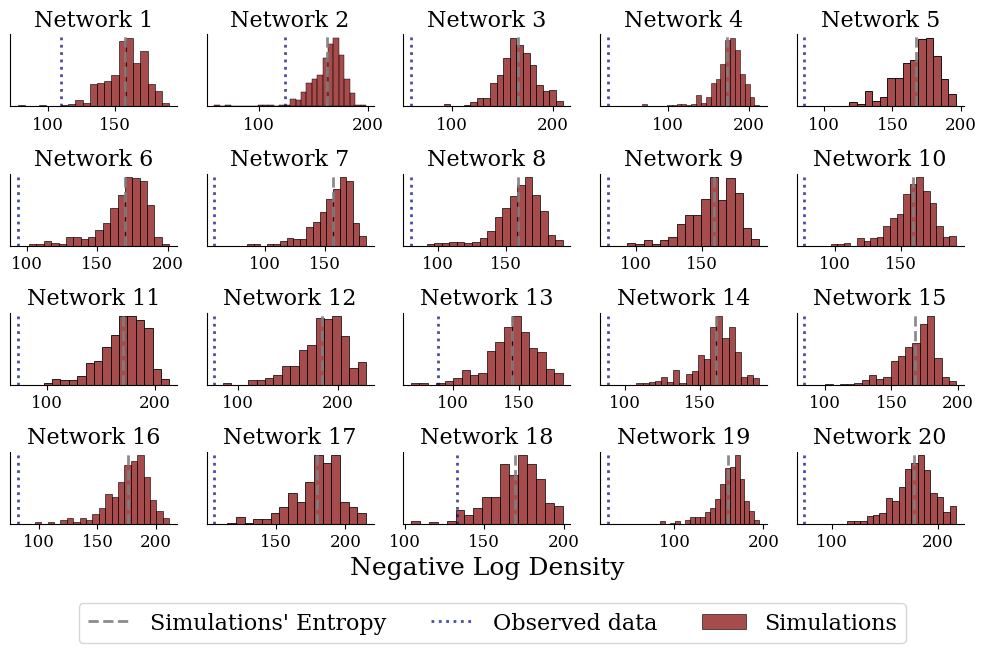

In [13]:
nrows = 4 
ncols = int(NUM_ENSEMBLE_MEMBERS/4)
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6))
for i in range(nrows):
    for j in range(ncols):
        n = i * 5 + j  # Calculate the corresponding index for NUM_ENSEMBLE_MEMBERS
        sns.histplot(val_lpdfs[n], ax=ax[i, j], label='Simulations', color=plotting_settings["colors"][0], alpha=ALPHA)
        ax[i, j].axvline(np.mean(val_lpdfs[n]), color='grey', label="Simulations' Entropy", lw=2, linestyle='dashed', alpha=0.9)
        ax[i, j].axvline(emp_lpdfs[n], color=plotting_settings["colors"][1], label='Observed data', lw=2, linestyle='dotted', alpha=ALPHA)
        sns.despine(ax=ax[i, j])
        ax[i, j].set_ylabel("")
        ax[i, j].tick_params(axis='x', labelsize=12) 
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"Network {n+1}", fontsize=16)
        ax[nrows - 1, 2].set_xlabel("Negative Log Density", fontsize=18)
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.5, -0.1))
#plt.legend(bbox_to_anchor=(0, 0), loc="lower left")
#ax[4, 0].legend(labels=['Observed Data', 'Surprisal (In-Distribution)'],loc='upper center', 
#             bbox_to_anchor=(0.5, -0.5),fancybox=False, shadow=False, ncol=1)
plt.tight_layout()
#plt.savefig("../../figures/levy_ood_typicality_separate.pdf", dpi=300, bbox_inches="tight")

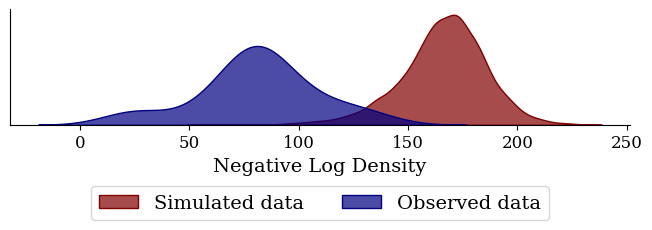

In [46]:
# Plot marginal of unstandardized log pdfs over ensemble members in a single plot
f, ax = plt.subplots(1, 1, figsize=(8, 1.5))
sns.kdeplot(np.concatenate(val_lpdfs), ax=ax, label='Simulated data', color=plotting_settings["colors"][0], fill=plotting_settings["colors"][0], alpha=ALPHA)
#ax.axvline(np.mean(val_lpdfs), color='gray', label='Entropy', linestyle='dashed')
sns.kdeplot(np.concatenate(emp_lpdfs), ax=ax, label='Observed data', color=plotting_settings["colors"][1], fill=plotting_settings["colors"][1], alpha=ALPHA)
sns.despine(ax=ax)
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=2, fontsize=14)
ax.set_xlabel("Negative Log Density", fontsize=14)
ax.set_ylabel('')
plt.xticks(fontsize=12)
ax.set_yticks([])
plt.savefig("../../figures/levy_ood_typicality_marginal_flat.pdf", dpi=300, bbox_inches="tight")

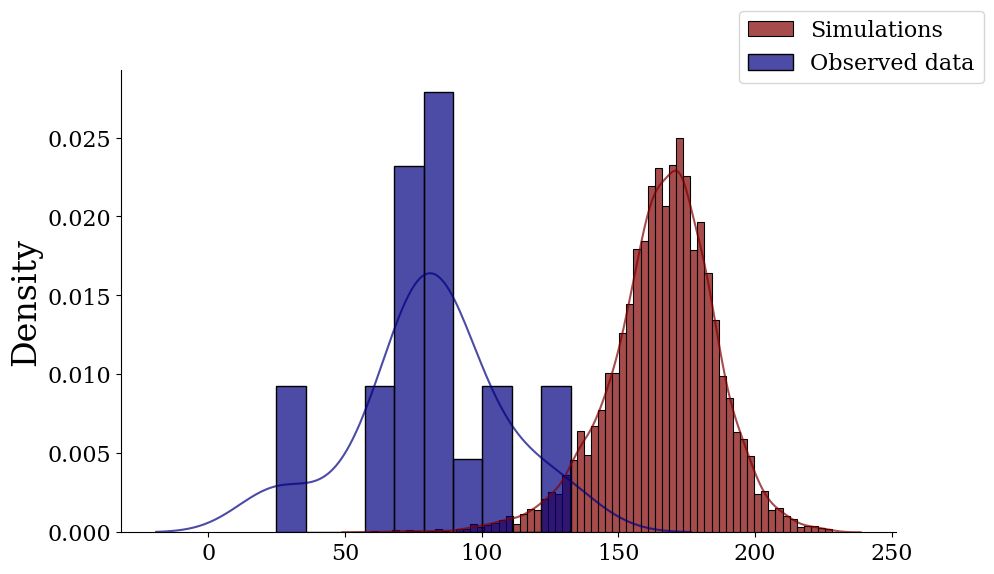

In [23]:
# Plot marginal log pdfs and histograms over ensemble members in a single plot
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(val_lpdfs_arr, ax=ax, label='Simulations', color=plotting_settings["colors"][0], alpha=ALPHA, stat="density")
sns.kdeplot(val_lpdfs_arr, ax=ax, color=plotting_settings["colors"][0], alpha=ALPHA)
#ax.axvline(np.mean(val_lpdfs_arr), color='gray', label='Entropy', linestyle='dashed')
sns.histplot(emp_lpdfs_arr, ax=ax, label='Observed data', color=plotting_settings["colors"][1], alpha=ALPHA, stat="density")
sns.kdeplot(emp_lpdfs_arr, ax=ax, color=plotting_settings["colors"][1], alpha=ALPHA)
sns.despine(ax=ax)
f.legend()

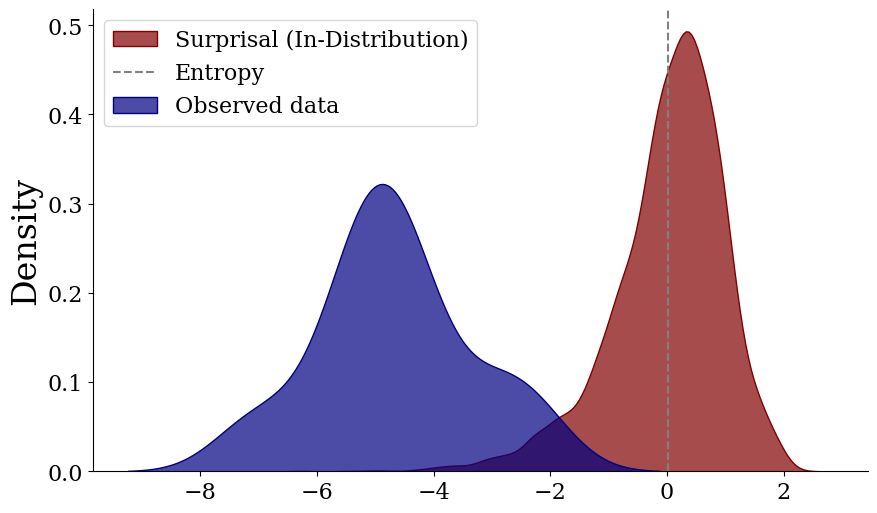

In [24]:
# Plot marginal of STANDARDIZED log pdfs over ensemble members in a single plot
from sklearn.preprocessing import StandardScaler

val_lpdfs_z = []
emp_lpdfs_z = []

for n in range(NUM_ENSEMBLE_MEMBERS):
    scaler = StandardScaler()
    joint_data = np.concatenate([val_lpdfs[n], emp_lpdfs[n]]).reshape(-1, 1)
    scaler.fit(joint_data)
    val_lpdfs_z.append(scaler.transform(val_lpdfs[n].reshape(-1, 1)))
    emp_lpdfs_z.append(scaler.transform(emp_lpdfs[n].reshape(-1, 1)))

f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.kdeplot(np.concatenate(val_lpdfs_z).squeeze(), ax=ax, label='Surprisal (In-Distribution)', color=plotting_settings["colors"][0], fill=plotting_settings["colors"][0], alpha=ALPHA)
ax.axvline(np.mean(np.concatenate(val_lpdfs_z)), color='gray', label='Entropy', linestyle='dashed')
sns.kdeplot(np.concatenate(emp_lpdfs_z).squeeze(), ax=ax, label='Observed data', color=plotting_settings["colors"][1], fill=plotting_settings["colors"][1], alpha=ALPHA)
sns.despine(ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))